In [1]:
import pandas as pd
import numpy as np
import sklearn.model_selection as sk_ms
import warnings
warnings.filterwarnings('ignore')

# data visualization
import matplotlib
import seaborn as sns
%matplotlib inline

from tqdm import tqdm

import pandas as pd
import numpy as np
from numpy import median

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.manifold import TSNE
from sklearn import preprocessing

from collections import Counter

import string
import re
from nltk.corpus import stopwords

import scipy
from scipy import hstack


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.linear_model import Ridge

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss

from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
# from sklearn.feature_selection.univariate_selection import SelectKBest, f_regression

C:\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
pd.set_option('display.max_columns', None)

In [22]:
df = pd.read_csv('glassdoor_reviews.csv')

In [23]:
df.head()

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons
0,AFH-Wealth-Management,2015-04-05,,Current Employee,NaN,2,4.0,3.0,NaN,2.0,3.0,3.0,x,o,r,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication."
1,AFH-Wealth-Management,2015-12-11,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",2,3.0,1.0,NaN,2.0,1.0,4.0,x,o,r,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...
2,AFH-Wealth-Management,2016-01-28,Office Administrator,"Current Employee, less than 1 year","Bromsgrove, England, England",1,1.0,1.0,NaN,1.0,1.0,1.0,x,o,x,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very..."
3,AFH-Wealth-Management,2016-04-16,,Current Employee,NaN,5,2.0,3.0,NaN,2.0,2.0,3.0,x,o,r,Over promised under delivered,Nice staff to work with,No career progression and salary is poor
4,AFH-Wealth-Management,2016-04-23,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",1,2.0,1.0,NaN,2.0,1.0,1.0,x,o,x,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr..."


In [5]:
# df_train, df_test = sk_ms.train_test_split(df, train_size = 0.8, random_state = 100)

# EDA

## 1. Getting insights about the dataset

The dataset containing 838566 entries and 18 columns.

In [6]:
df.shape

(838566, 18)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838566 entries, 0 to 838565
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   firm                 838566 non-null  object 
 1   date_review          838566 non-null  object 
 2   job_title            838566 non-null  object 
 3   current              838566 non-null  object 
 4   location             541228 non-null  object 
 5   overall_rating       838566 non-null  int64  
 6   work_life_balance    688672 non-null  float64
 7   culture_values       647193 non-null  float64
 8   diversity_inclusion  136066 non-null  float64
 9   career_opp           691065 non-null  float64
 10  comp_benefits        688484 non-null  float64
 11  senior_mgmt          682690 non-null  float64
 12  recommend            838566 non-null  object 
 13  ceo_approv           838566 non-null  object 
 14  outlook              838566 non-null  object 
 15  headline         

### Drop Duplicates

In [24]:
duplicate = df[['firm','overall_rating','headline','pros','cons']].duplicated()
df = df.loc[duplicate == False]
df = df.reset_index(drop = True)
print('Drop Duplicated:',duplicate.sum())

Drop Duplicated: 34945


### Missings

In [78]:
percent_missing_col = df.isnull().sum() * 100 / len(df)
missing_col = pd.DataFrame({'Percent Missing': percent_missing_col})
missing_col

,Percent Missing
firm,0.000000
date_review,0.000000
job_title,0.000000
current,0.000000
location,35.475056
overall_rating,0.000000
work_life_balance,17.905082
culture_values,22.785368
diversity_inclusion,83.749056
career_opp,17.615393


### Numerical variables

In [25]:
num_feat = df.select_dtypes(exclude = ['object']).columns
num_feat

Index(['overall_rating', 'work_life_balance', 'culture_values',
       'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt'],
      dtype='object')

In [26]:
df.describe()

,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt
count,803621.000000,659732.000000,620513.000000,130596.000000,662060.000000,659548.000000,653998.000000
mean,3.657226,3.374863,3.590889,3.964562,3.459211,3.402608,3.178728
std,1.176911,1.306761,1.325137,1.193047,1.274092,1.220864,1.332894
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000
50%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000
75%,5.000000,4.000000,5.000000,5.000000,5.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


### Categorical variables

In [12]:
cat_feat = df.select_dtypes(include = ['object']).columns
cat_feat

Index(['firm', 'date_review', 'job_title', 'current', 'location', 'recommend',
       'ceo_approv', 'outlook', 'headline', 'pros', 'cons'],
      dtype='object')

In [13]:
df.describe(include='object')

,firm,date_review,job_title,current,location,recommend,ceo_approv,outlook,headline,pros,cons
count,803621,803621,803621,803621,518536,803621,803621,803621,801525,803621,803613
unique,428,4813,62275,29,14455,3,4,4,390455,778560,777134
top,McDonald-s,2021-01-13,Anonymous Employee,Current Employee,"London, England, England",v,o,v,Good,Great company to work for,None that I can think of
freq,49180,1703,155730,200323,57249,410378,298024,289616,13685,697,1125


## 2. Univariate data analysis

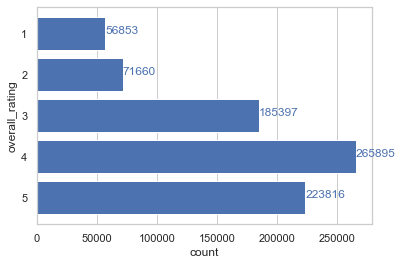

In [11]:
# Plot the distribution of firm
x = df['overall_rating'].value_counts(dropna = False).index.fillna(value = 'nan')
y = df['overall_rating'].value_counts(dropna = False).values

# plt.figure(figsize=[6,2])
plt.barh(x, y)
for i, val in enumerate(y):
    plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('overall_rating')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

#### Top 20 firms with the most reviews

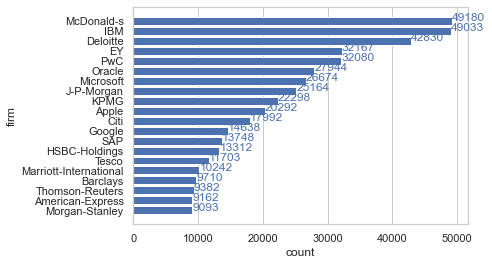

In [14]:
# Plot the distribution of firm
x = df['firm'].value_counts(dropna = False).index.fillna(value = 'nan')[:20]
y = df['firm'].value_counts(dropna = False).values[:20]

# plt.figure(figsize=[6,2])
plt.barh(x, y)
for i, val in enumerate(y):
    plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('firm')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

#### Top 20 jobs with the most reviews

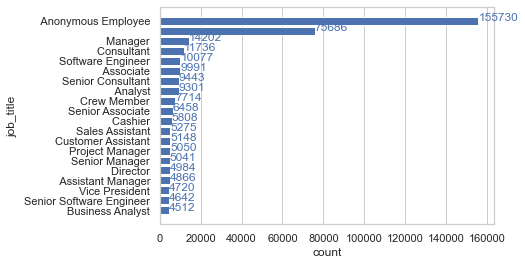

In [48]:
# Plot the distribution of job_title
x = df['job_title'].value_counts(dropna = False).index.fillna(value = 'nan')[:20]
y = df['job_title'].value_counts(dropna = False).values[:20]

# plt.figure(figsize=[6,1])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('job_title')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

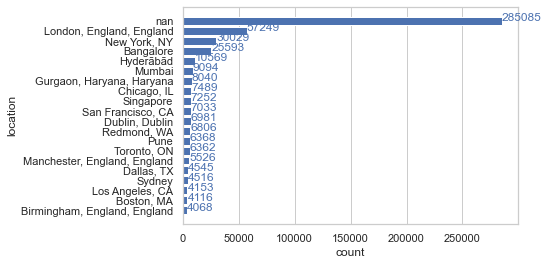

In [38]:
# Plot the distribution of location
x = df['location'].value_counts(dropna = False).index.fillna(value = 'nan')[:20]
y = df['location'].value_counts(dropna = False).values[:20]

# plt.figure(figsize=[6,1])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='b')
plt.gca().invert_yaxis()
plt.ylabel('location')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

## 3. Bivariate Data Analysis

### Numerical variables & overall rating

In [27]:
# Filtering out the numerical features in a different data frame
df_num = df[num_feat]
df_num.head()

,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt
0,2,4.0,3.0,NaN,2.0,3.0,3.0
1,2,3.0,1.0,NaN,2.0,1.0,4.0
2,1,1.0,1.0,NaN,1.0,1.0,1.0
3,5,2.0,3.0,NaN,2.0,2.0,3.0
4,1,2.0,1.0,NaN,2.0,1.0,1.0


In [28]:
# Correlation between numerical variables and overall rating
df_corr = df_num.corr()['overall_rating'][:-1]
corr_feat = df_corr.sort_values(ascending = False)
corr_feat

overall_rating         1.000000
culture_values         0.767038
career_opp             0.715596
diversity_inclusion    0.632416
comp_benefits          0.611280
work_life_balance      0.565487
Name: overall_rating, dtype: float64

### Categorical variables & price

In [31]:
# Filtering out the categorical features in a different data frame
cat_feat = df.select_dtypes(include = ['object']).columns
cat_feat

Index(['firm', 'date_review', 'job_title', 'current', 'location', 'recommend',
       'ceo_approv', 'outlook', 'headline', 'pros', 'cons'],
      dtype='object')

In [53]:
firm_avg_rating

,mean,std,count
firm,,,
AFH-Wealth-Management,2.904762,1.720036,63
AJ-Bell,3.359649,1.540757,114
ALDI,3.422127,1.345284,931
AQA,3.622807,1.299356,114
ASDA,3.351733,1.248474,4674
...,...,...,...
i-Net-Solution,4.000000,1.414214,4
ibis,3.358333,1.200811,120
mydentist-UK,3.305263,1.459187,95


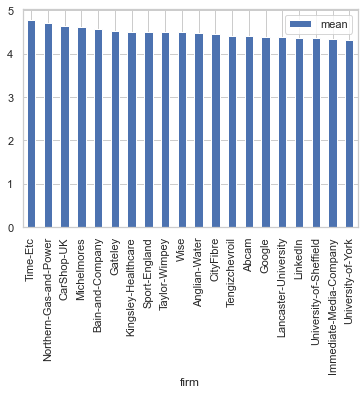

In [67]:
import pandas as pd
import seaborn as sns

# Group the data by the "firm" variable and compute the mean of the "overall_rating" variable
firm_avg_rating = df.groupby("firm")["overall_rating"].agg(["mean", "std", "count"])

# Sort the mean values in descending order and keep only the top 20 categories
top_firms = firm_avg_rating[firm_avg_rating['count'] >= 20].sort_values(by = 'mean',ascending=False).head(20)

top_firms[['mean']].plot(kind="bar")
plt.show()

# plt.figure(figsize=(20,20))

# # Create a figure and axes objects
# fig, ax1 = plt.subplots()

# # Plot the mean on the first set of y-axes
# ax1.plot(top_firms["mean"], color="blue")
# ax1.set_ylabel("Mean Rating", color="blue")

# # Create a second set of y-axes that share the same x-axis
# ax2 = ax1.twinx()

# # Plot the standard deviation on the second set of y-axes
# ax2.plot(top_firms["std"], color="red")
# ax2.set_ylabel("Standard Deviation", color="red")

# # Set the title and x-axis label
# ax1.set_title("Average Ratings by Firm")
# ax1.set_xlabel("Firm")

# # Show the plot
# plt.show()

In [68]:
top_firms

,mean,std,count
firm,,,
Time-Etc,4.785714,0.716894,42
Northern-Gas-and-Power,4.719682,0.909747,503
CarShop-UK,4.651163,0.987479,258
Michelmores,4.610390,0.860781,77
Bain-and-Company,4.559757,0.809048,3623
Gateley,4.525424,0.878006,59
Kingsley-Healthcare,4.500000,1.187051,122
Sport-England,4.500000,0.834058,24
Taylor-Wimpey,4.497396,0.893839,384


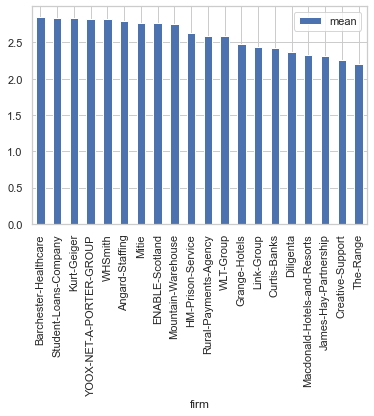

In [69]:
# Group the data by the "firm" variable and compute the mean of the "overall_rating" variable
firm_avg_rating = df.groupby("firm")["overall_rating"].agg(["mean", "std", "count"])

# Sort the mean values in descending order and keep only the tail 20 categories
tail_firms = firm_avg_rating[firm_avg_rating['count'] >= 20].sort_values(by = 'mean',ascending=False).tail(20)

tail_firms[['mean']].plot(kind="bar")
plt.show()

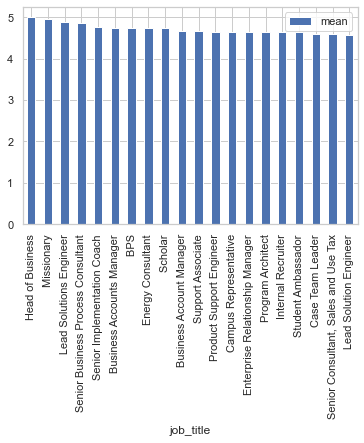

In [70]:
# Group the data by the "job_title" variable and compute the mean of the "overall_rating" variable
firm_avg_rating = df.groupby("job_title")["overall_rating"].agg(["mean", "std", "count"])

# Sort the mean values in descending order and keep only the top 20 categories
top_jobs = firm_avg_rating[firm_avg_rating['count'] >= 20].sort_values(by = 'mean',ascending=False).head(20)

top_jobs[['mean']].plot(kind="bar")
plt.show()

In [71]:
top_jobs

,mean,std,count
job_title,,,
Head of Business,5.000000,0.000000,20
Missionary,4.966667,0.182574,30
Lead Solutions Engineer,4.882353,0.409338,34
Senior Business Process Consultant,4.857143,0.356348,28
Senior Implementation Coach,4.761905,0.768424,21
Business Accounts Manager,4.750000,0.910465,20
BPS,4.750000,0.638666,20
Energy Consultant,4.735849,0.880361,53
Scholar,4.730769,0.666795,26


In [30]:
def add_n_obs(df,group_col,y):
    medians_dict = {grp[0]:grp[1][y].median() for grp in df.groupby(group_col)}
    xticklabels = [x.get_text() for x in plt.gca().get_xticklabels()]
    n_obs = df.groupby(group_col)[y].size().values
    for (x, xticklabel), n_ob in zip(enumerate(xticklabels), n_obs):
        plt.text(x, medians_dict[xticklabel]*1.01, "#obs : "+str(n_ob), horizontalalignment='center', fontdict={'size':12}, color='white')

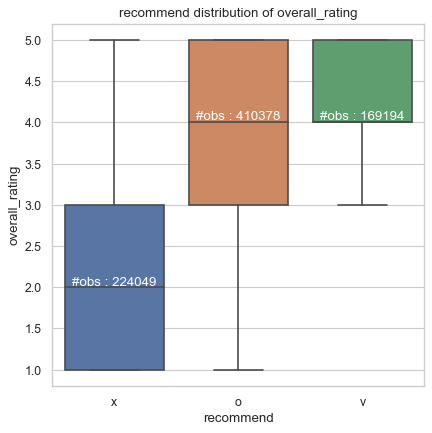

In [33]:
# Plot the variation of overall_rating with the recommend
plt.figure(figsize=(6,6), dpi= 80)
sns.boxplot(x = 'recommend', y='overall_rating', data=df, showfliers=False)

add_n_obs(df,group_col='recommend',y='overall_rating') 

plt.title('recommend distribution of overall_rating')
plt.show()

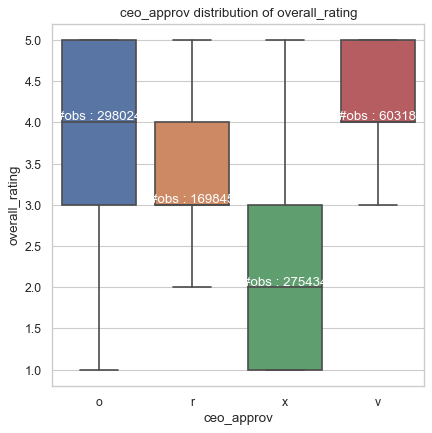

In [34]:
# Plot the variation of overall_rating with the ceo_approv
plt.figure(figsize=(6,6), dpi= 80)
sns.boxplot(x = 'ceo_approv', y='overall_rating', data=df, showfliers=False)

add_n_obs(df,group_col='ceo_approv',y='overall_rating') 

plt.title('ceo_approv distribution of overall_rating')
plt.show()

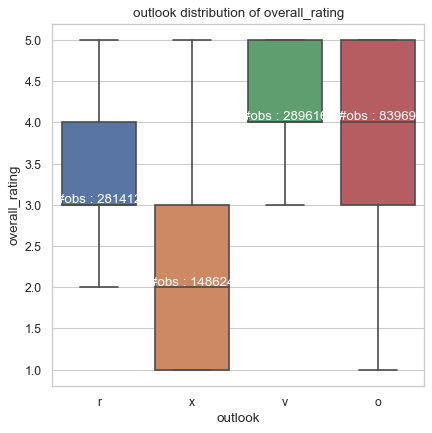

In [35]:
# Plot the variation of overall_rating with the outlook
plt.figure(figsize=(6,6), dpi= 80)
sns.boxplot(x = 'outlook', y='overall_rating', data=df, showfliers=False)

add_n_obs(df,group_col='outlook',y='overall_rating') 

plt.title('outlook distribution of overall_rating')
plt.show()

## 4. Multivariate Data Analysis

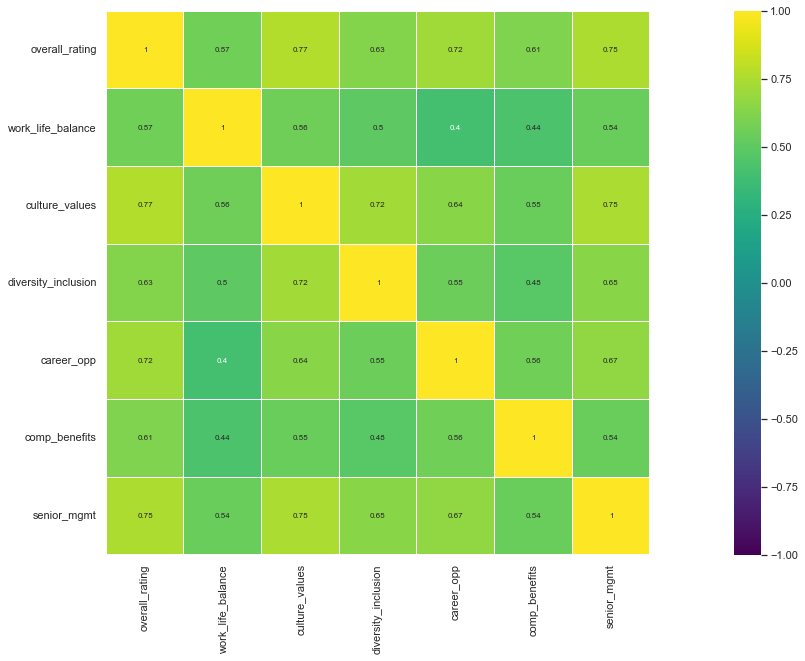

In [37]:
# Plot the correlation between numerical variables
corr = df_num.corr()
plt.figure(figsize=(30, 10))
sns.heatmap(corr,
cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
annot=True, annot_kws={"size": 8}, square=True);

## 5. Cleaning the data: Pre-processing

In [73]:
from nltk import sent_tokenize,word_tokenize
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint
import nltk
from nltk.stem import PorterStemmer

In [74]:
import nltk
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def text_processor(raw):
    if pd.isna(raw):
        return ''
    processed = [stemmer.stem(token) for token in word_tokenize(raw.lower())
        if token not in STOPWORDS and token.isalnum()]
    return ' '.join(processed)

In [75]:
print(df['pros'][0])
text_processor(df['pros'][0])

Very friendly and welcoming to new staff. Easy going ethic.


'friendli welcom new staff easi go ethic'

In [42]:
df_reduced = df[['overall_rating','headline','pros','cons','firm','date_review']]
df_reduced.head()

,overall_rating,headline,pros,cons,firm,date_review
0,2,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication.",AFH-Wealth-Management,2015-04-05
1,2,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,AFH-Wealth-Management,2015-12-11
2,1,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",AFH-Wealth-Management,2016-01-28
3,5,Over promised under delivered,Nice staff to work with,No career progression and salary is poor,AFH-Wealth-Management,2016-04-16
4,1,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",AFH-Wealth-Management,2016-04-23


In [ ]:
df_reduced['headline_processed'] = df_reduced['headline'].apply(lambda x: text_processor(x))
df_reduced['pros_processed'] = df_reduced['pros'].apply(lambda x: text_processor(x))
df_reduced['cons_processed'] = df_reduced['pros'].apply(lambda x: text_processor(x))
df_reduced.head()

In [ ]:
def draw_wordcloud(min_size=0,STOPWORDS=[]):
    word_list=[]
    prob_total = 0
    for word,prob in lda.show_topic(topicnum,topn=50):
        prob_total +=prob
    for word,prob in lda.show_topic(topicnum,topn=50):
        if word in STOPWORDS or  len(word) < min_size:
            continue

        freq = int(prob/prob_total*100)
        alist=[word]
        word_list.extend(alist*freq)

    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    %matplotlib inline
    from random import shuffle
    shuffle(word_list)
    text = ' '.join(word_list)
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',max_words=20).generate(text)

    plt.axis('off')
    plt.imshow(wordcloud)

    return None

## 7. Mapping

8. Convert Categorical data items into numerical data items.

9. Scaling the data

10. Training Model on this data.

https://medium.com/@srajangupta5/the-best-beginners-guide-to-exploratory-data-analysis-eda-the-only-guide-you-will-ever-need-4409e6be4423

https://towardsdatascience.com/mercari-price-suggestion-97ff15840dbd

https://github.com/aruns2120/Mercari-Price-Suggestion-Challenge/blob/master/Mercari_PriceSuggestion_EDA.ipynb